#Generative Adversarial Network

*   We are implementing a GAN to generate images of cats
*   I am using a dataset I found in kaggle
*   It contains images of cats




In [1]:
from google.colab import files
files.upload()  # Upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pranathisreeja","key":"628f0f47439a5a506383ba21afb2d72e"}'}

#Load the dataset

In [2]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d borhanitrash/cat-dataset

# Unzip the dataset
!unzip cat-dataset.zip -d cats

Streaming output truncated to the last 5000 lines.
  inflating: cats/cats/Data/cat_550.png  
  inflating: cats/cats/Data/cat_5500.png  
  inflating: cats/cats/Data/cat_5501.png  
  inflating: cats/cats/Data/cat_5502.png  
  inflating: cats/cats/Data/cat_5503.png  
  inflating: cats/cats/Data/cat_5504.png  
  inflating: cats/cats/Data/cat_5505.png  
  inflating: cats/cats/Data/cat_5506.png  
  inflating: cats/cats/Data/cat_5507.png  
  inflating: cats/cats/Data/cat_5508.png  
  inflating: cats/cats/Data/cat_5509.png  
  inflating: cats/cats/Data/cat_551.png  
  inflating: cats/cats/Data/cat_5510.png  
  inflating: cats/cats/Data/cat_5511.png  
  inflating: cats/cats/Data/cat_5512.png  
  inflating: cats/cats/Data/cat_5513.png  
  inflating: cats/cats/Data/cat_5514.png  
  inflating: cats/cats/Data/cat_5515.png  
  inflating: cats/cats/Data/cat_5516.png  
  inflating: cats/cats/Data/cat_5517.png  
  inflating: cats/cats/Data/cat_5518.png  
  inflating: cats/cats/Data/cat_5519.png  
  inf

In [3]:
import tensorflow as tf

#Preprocess the dataset

In [4]:
import os

# Set path to images
IMG_DIR = './cats/cats/Data/'

# Get all image file paths, EXCLUDING directories
image_paths = [os.path.join(IMG_DIR, fname) for fname in os.listdir(IMG_DIR)
                if os.path.isfile(os.path.join(IMG_DIR, fname))]

image_paths = image_paths[:10000]

# Print the number of image paths found
print(f"Found {len(image_paths)} image paths.")

# Preprocessing function
def preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)  # Decode JPEG
    img = tf.image.resize(img, [64, 64])  # Resize to 64x64
    img = (img / 127.5) - 1.0  # Normalize to [-1, 1]
    return img

# Create TensorFlow Dataset
def load_dataset(batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Load dataset
batch_size = 64
cats_dataset = load_dataset(batch_size)

# Example: Iterate through batches
for batch in cats_dataset.take(1):
    print(batch.shape)  # Should print (batch_size, 64, 64, 3)

Found 10000 image paths.
(64, 64, 64, 3)


#Visualising the datset

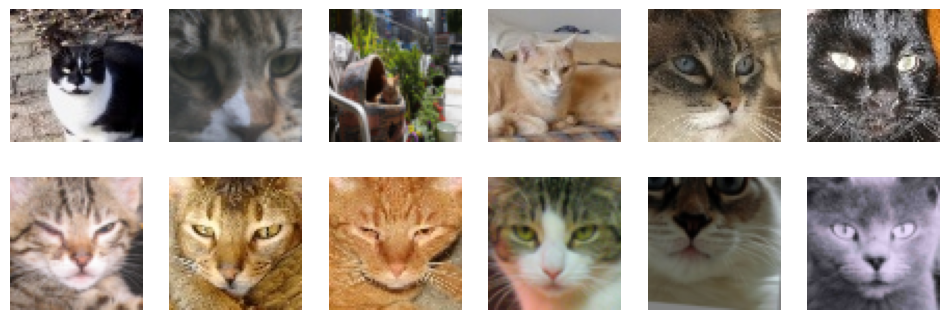

In [5]:
import matplotlib.pyplot as plt

# Function to display 12 images in a 2x6 grid
def display_images(dataset, num_images=12, rows=2, cols=6):
    plt.figure(figsize=(12, 4))  # Set the figure size
    for i, img in enumerate(dataset.take(num_images).unbatch().as_numpy_iterator()):
        if i >= num_images:
            break
        # Rescale pixel values from [-1, 1] to [0, 1] for display
        img = (img + 1) / 2.0
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

# Display images from the Cats dataset
display_images(cats_dataset)

#Model 1

#Generator

In [6]:
from tensorflow.keras import layers

In [7]:
def make_generator_model(noise_dim=100):
    model = tf.keras.Sequential([
        # Dense layer to project noise into a 16x16x256 tensor
        layers.Input(shape=(noise_dim,)),
        layers.Dense(16 * 16 * 256, use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((16, 16, 256)),  # Reshape into 16x16x256 tensor

        # Transposed Convolution: 16x16x256 -> 32x32x128
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same", use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        # Final Transposed Convolution: 32x32x128 -> 64x64x3
        layers.Conv2DTranspose(3, kernel_size=4, strides=2, padding="same", activation="tanh")
    ])

    return model

In [8]:
# Instantiate the generator
noise_dim = 100  # Dimension of the random noise input
generator = make_generator_model(noise_dim)
generator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 65536)               │       6,553,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 65536)               │         262,144 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 32, 32, 128)         │         524,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 64, 64, 3)           │           6,147 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,346,691 (28.03 MB)

 Trainable params: 7,215,363 (27.52 MB)

 Non-trainable params: 131,328 (513.00 KB)

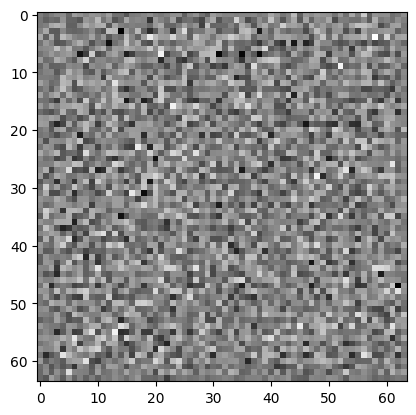

In [9]:
# Generate a batch of random noise
random_noise = tf.random.normal([1, noise_dim])

# Generate an image from the noise
generated_image = generator(random_noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

#Discriminator

In [10]:
def make_discriminator_model(image_size=64):
    model = tf.keras.Sequential([
        # Input: 64x64x3 -> 32x32x64
        layers.Input(shape=(image_size, image_size, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),

        # Downsample: 32x32x64 -> 16x16x128
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),

        # Downsample: 16x16x128 -> 8x8x256
        layers.Conv2D(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),

        # Flatten and output: 8x8x256 -> 1
        layers.Flatten(),
        layers.Dense(1, activation="sigmoid")  # Sigmoid outputs a probability
    ])

    return model

In [11]:
# Instantiate the discriminator
image_size = 64  # Input image size
discriminator = make_discriminator_model(image_size)
discriminator.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 64)          │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │          16,385 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 675,265 (2.58 MB)

 Trainable params: 675,265 (2.58 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Generate a fake image from the generator
random_noise = tf.random.normal([1, 100])  # Noise vector
fake_image = generator(random_noise, training=False)

# Test the discriminator with the fake image
decision = discriminator(fake_image, training=False)
print("Discriminator output for fake image:", decision.numpy())

# Test the discriminator with a real image
real_image = tf.random.uniform([1, 64, 64, 3], minval=-1, maxval=1)  # Simulate real image
decision = discriminator(real_image, training=False)
print("Discriminator output for real image:", decision.numpy())

Discriminator output for fake image: [[0.49983245]]
Discriminator output for real image: [[0.49127898]]


#Define the loss functions and optimizers

In [13]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

Discriminator Loss

In [14]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

Generator Loss

In [15]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [16]:
# Simulate discriminator outputs
real_output = tf.random.uniform([16, 1], minval=0.8, maxval=1.0)  # Simulate real logits
fake_output = tf.random.uniform([16, 1], minval=0.0, maxval=0.2)  # Simulate fake logits

# Compute losses
d_loss = discriminator_loss(real_output, fake_output)
g_loss = generator_loss(fake_output)

print("Discriminator loss:", d_loss.numpy())
print("Generator loss:", g_loss.numpy())

Discriminator loss: 1.0802138
Generator loss: 0.65290385


In [17]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

#Define the training loop

In [18]:
EPOCHS = 100
num_examples_to_generate = 4

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [19]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [20]:
generator_losses = []
discriminator_losses = []

In [21]:
import time
from IPython.display import clear_output

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      gen_loss, disc_loss = train_step(image_batch)

    clear_output(wait=True)
    generate_images(generator, epoch + 1, seed, output_dir)

    generator_losses.append(gen_loss.numpy())       # Store the losses
    discriminator_losses.append(disc_loss.numpy())

    print(f'Epoch {epoch + 1}, Gen Loss: {gen_loss.numpy()}, Disc Loss: {disc_loss.numpy()}, Time: {time.time() - start:.2f} sec')

  # Generate after the final epoch
  clear_output(wait=True)
  generate_images(generator, epochs, seed, output_dir)

In [22]:
# Directory to save images
output_dir = "generated_images_model1"
os.makedirs(output_dir, exist_ok=True)

def generate_images(model, epoch, test_input, output_dir):
    # Run the model in inference mode
    predictions = model(test_input, training=False)

    # Create a figure to plot the images
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(2, 2, i + 1)
        # Scale predictions to [0, 255] and cast to uint8
        rgb_image = tf.cast((predictions[i] * 127.5 + 127.5), tf.uint8)
        plt.imshow(rgb_image.numpy())  # Convert tensor to NumPy array for visualization
        plt.axis('off')

    plt.show()

    # Save images at every 10th epoch
    if epoch % 10 == 0:
        file_path = os.path.join(output_dir, f"epoch_{epoch}.png")
        fig.savefig(file_path)  # Save the figure as an image file
        print(f"Saved image for epoch {epoch} at {file_path}")

    plt.close(fig)  # Close the figure to free memory


#Train the model

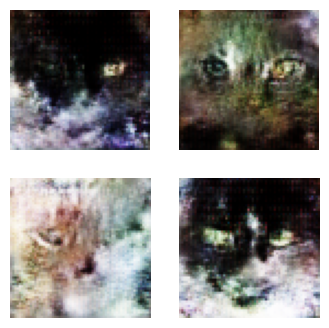

Saved image for epoch 100 at generated_images_model1/epoch_100.png


In [23]:
train(cats_dataset, EPOCHS)

#Plotting the losses

Minimum Generator Loss: 0.91697096824646
Minimum Discriminator Loss: 0.016647767275571823


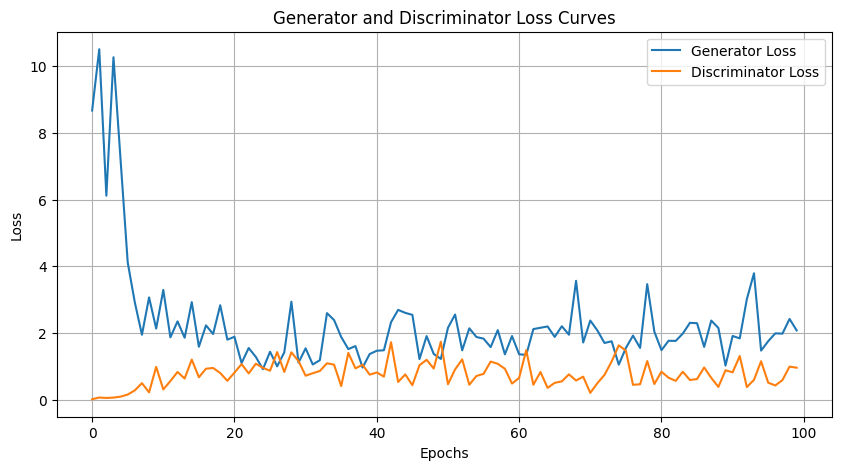

In [25]:
# Find the minimum loss for both
min_generator_loss = min(generator_losses)
min_discriminator_loss = min(discriminator_losses)

# Print minimum losses
print(f"Minimum Generator Loss: {min_generator_loss}")
print(f"Minimum Discriminator Loss: {min_discriminator_loss}")

# Plot the loss curves
plt.figure(figsize=(10, 5))
plt.plot(generator_losses, label="Generator Loss")
plt.plot(discriminator_losses, label="Discriminator Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Generator and Discriminator Loss Curves")
plt.legend()
plt.grid(True)
plt.show()

#Another Model

#Generator

In [26]:
def make_generator_model2(noise_dim=100):
    model = tf.keras.Sequential([
        # Dense layer to project noise into a 8x8x512 tensor
        layers.Input(shape=(noise_dim,)),
        layers.Dense(8 * 8 * 512, use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((8, 8, 512)),

        # First Transposed Convolution: 8x8x512 -> 16x16x256
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same", use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        # Second Transposed Convolution: 16x16x256 -> 32x32x128
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same", use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        # Final Transposed Convolution: 32x32x128 -> 64x64x3
        layers.Conv2DTranspose(3, kernel_size=4, strides=2, padding="same", activation="tanh")
    ])

    return model

In [27]:
# Instantiate the generator
noise_dim = 100  # Dimension of the random noise input
generator2 = make_generator_model2(noise_dim)
generator2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                      │ (None, 32768)               │       3,276,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32768)               │         131,072 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 16, 16, 256)         │       2,097,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 32, 32, 128)         │         524,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 64, 64, 3)           │           6,147 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,036,995 (23.03 MB)

 Trainable params: 5,970,691 (22.78 MB)

 Non-trainable params: 66,304 (259.00 KB)

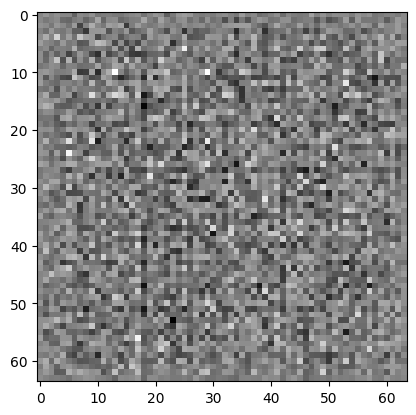

In [28]:
# Generate a batch of random noise
random_noise2 = tf.random.normal([1, noise_dim])

# Generate an image from the noise
generated_image2 = generator2(random_noise2, training=False)

plt.imshow(generated_image2[0, :, :, 0], cmap='gray')

#Discriminator

In [29]:
def make_discriminator_model2(image_size=64):
    model = tf.keras.Sequential([
        # Input: 64x64x3 -> 32x32x64
        layers.Input(shape=(image_size, image_size, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),

        # Downsample: 32x32x64 -> 16x16x128
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),

        # Downsample: 16x16x128 -> 8x8x256
        layers.Conv2D(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),

        # Flatten and output: 8x8x256 -> 1
        layers.Flatten(),
        layers.Dense(1, activation="sigmoid")  # Sigmoid outputs a probability
    ])

    return model

In [30]:
# Instantiate the discriminator
image_size = 64  # Input image size
discriminator2 = make_discriminator_model2(image_size)
discriminator2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 64)          │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 16, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_9 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_10 (LeakyReLU)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │          16,385 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 675,265 (2.58 MB)

 Trainable params: 675,265 (2.58 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Generate a fake image from the generator
random_noise2 = tf.random.normal([1, 100])  # Noise vector
fake_image2 = generator2(random_noise2, training=False)

# Test the discriminator with the fake image
decision2 = discriminator2(fake_image2, training=False)
print("Discriminator output for fake image:", decision2.numpy())

# Test the discriminator with a real image
real_image2 = tf.random.uniform([1, 64, 64, 3], minval=-1, maxval=1)  # Simulate real image
decision2 = discriminator2(real_image2, training=False)
print("Discriminator output for real image:", decision2.numpy())

Discriminator output for fake image: [[0.4999957]]
Discriminator output for real image: [[0.46882117]]


In [32]:
generator_optimizer2 = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer2 = tf.keras.optimizers.Adam(1e-4)

#Define the training loop for second model

In [33]:
EPOCHS = 100
num_examples_to_generate = 4

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed2 = tf.random.normal([num_examples_to_generate, noise_dim])

In [34]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator2(noise, training=True)

      real_output = discriminator2(images, training=True)
      fake_output = discriminator2(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator2.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator2.trainable_variables)

    generator_optimizer2.apply_gradients(zip(gradients_of_generator, generator2.trainable_variables))
    discriminator_optimizer2.apply_gradients(zip(gradients_of_discriminator, discriminator2.trainable_variables))

    return gen_loss, disc_loss

In [35]:
generator_losses2 = []
discriminator_losses2 = []

In [36]:
import time
from IPython.display import clear_output

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      gen_loss, disc_loss = train_step(image_batch)

    clear_output(wait=True)
    generate_images(generator2, epoch + 1, seed2, output_dir_new)

    generator_losses2.append(gen_loss.numpy())
    discriminator_losses2.append(disc_loss.numpy())

    print(f'Epoch {epoch + 1}, Gen Loss: {gen_loss.numpy()}, Disc Loss: {disc_loss.numpy()}, Time: {time.time() - start:.2f} sec')

  # Generate after the final epoch
  clear_output(wait=True)
  generate_images(generator2, epochs, seed, output_dir_new)

In [37]:
# Directory to save images
output_dir_new = "generated_images_model2"
os.makedirs(output_dir_new, exist_ok=True)

def generate_images(model, epoch, test_input, output_dir_new):
    # Run the model in inference mode
    predictions = model(test_input, training=False)

    # Create a figure to plot the images
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(2, 2, i + 1)
        # Scale predictions to [0, 255] and cast to uint8
        rgb_image = tf.cast((predictions[i] * 127.5 + 127.5), tf.uint8)
        plt.imshow(rgb_image.numpy())  # Convert tensor to NumPy array for visualization
        plt.axis('off')

    plt.show()

    # Save images at every 10th epoch
    if epoch % 10 == 0:
        file_path = os.path.join(output_dir_new, f"epoch_{epoch}.png")
        fig.savefig(file_path)  # Save the figure as an image file
        print(f"Saved image for epoch {epoch} at {file_path}")

    plt.close(fig)  # Close the figure to free memory


#Train the model

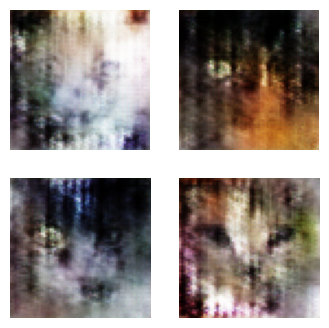

Saved image for epoch 100 at generated_images_model2/epoch_100.png


In [38]:
train(cats_dataset, EPOCHS)

#Plotting losses

Minimum Generator Loss: 0.7711698412895203
Minimum Discriminator Loss: 0.14116424322128296


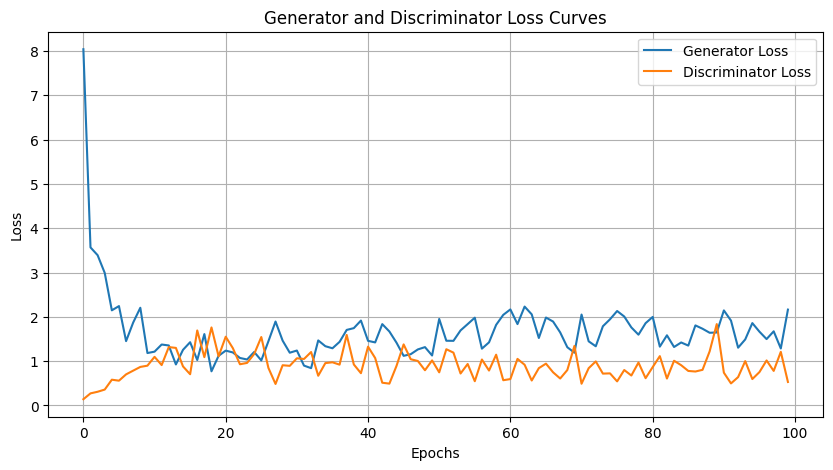

In [39]:
# Find the minimum loss for both
min_generator_loss_new = min(generator_losses2)
min_discriminator_loss_new = min(discriminator_losses2)

# Print minimum losses
print(f"Minimum Generator Loss: {min_generator_loss_new}")
print(f"Minimum Discriminator Loss: {min_discriminator_loss_new}")

# Plot the loss curves
plt.figure(figsize=(10, 5))
plt.plot(generator_losses2, label="Generator Loss")
plt.plot(discriminator_losses2, label="Discriminator Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Generator and Discriminator Loss Curves")
plt.legend()
plt.grid(True)
plt.show()

#Comparing the images from both the models

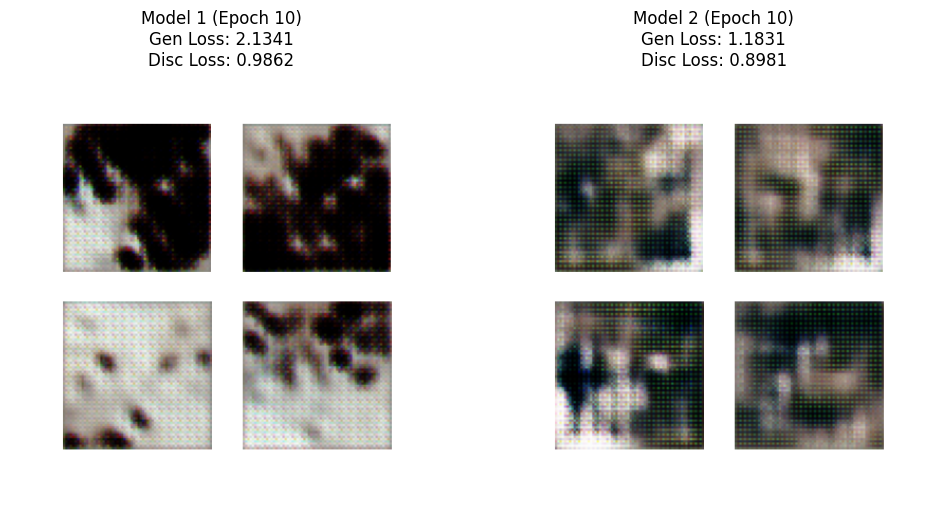

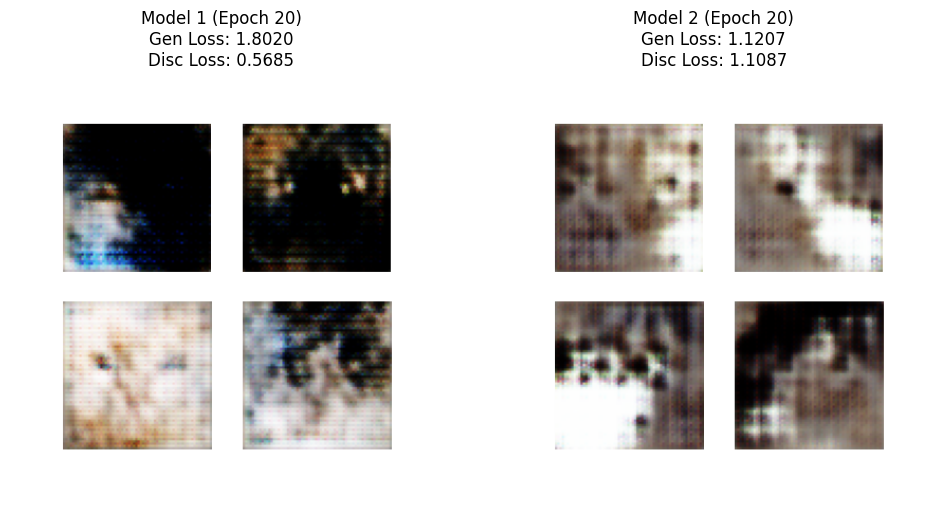

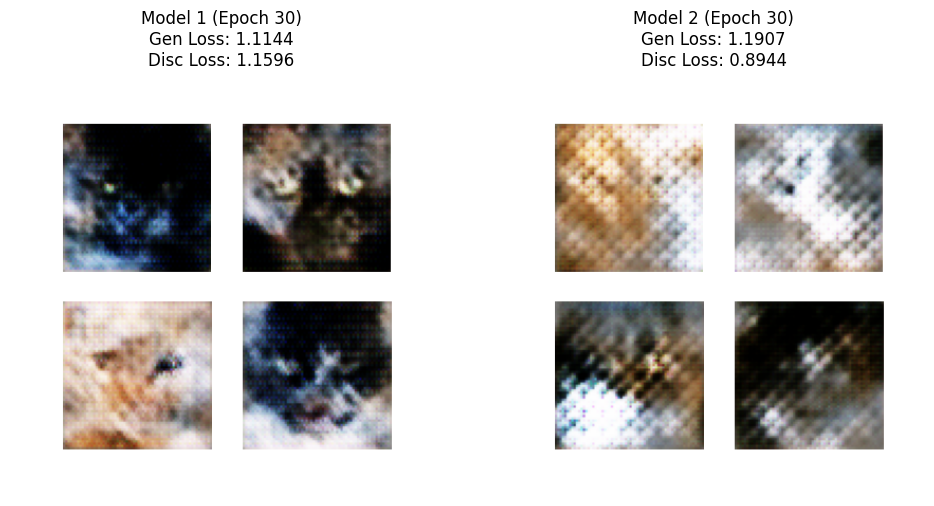

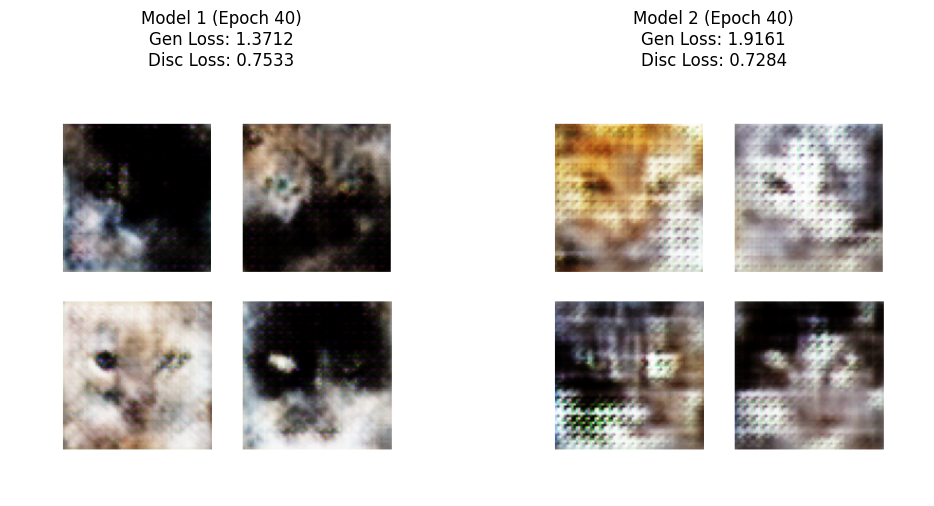

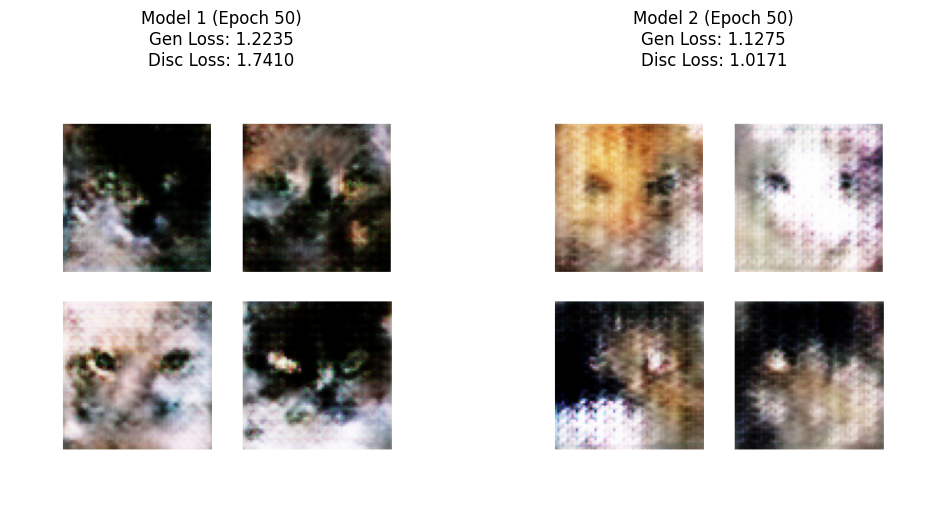

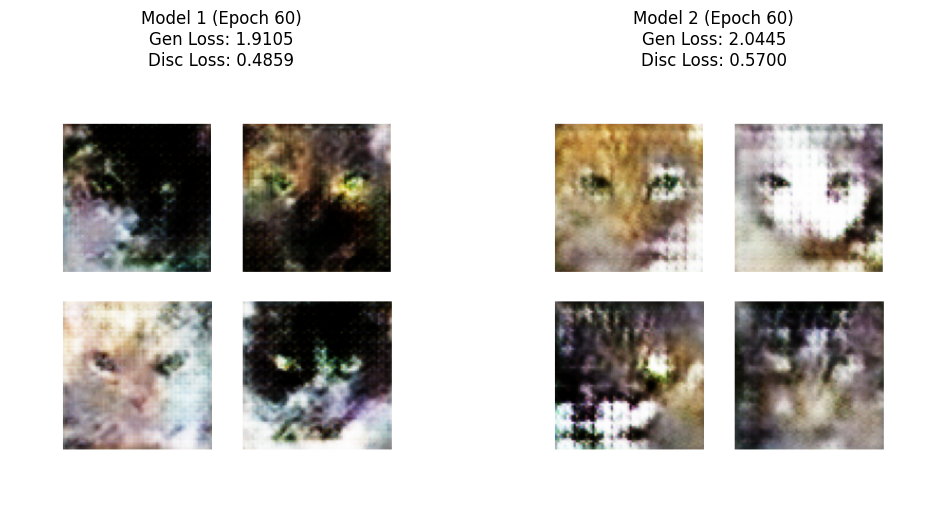

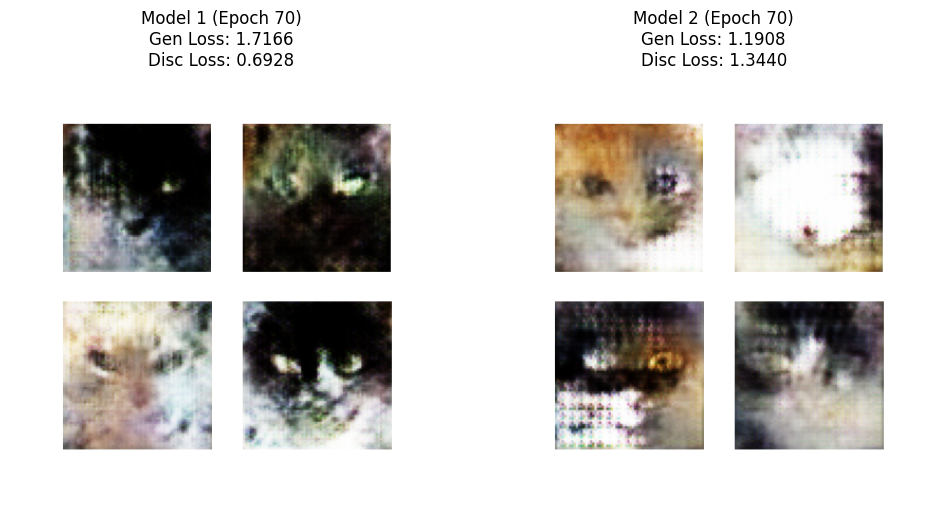

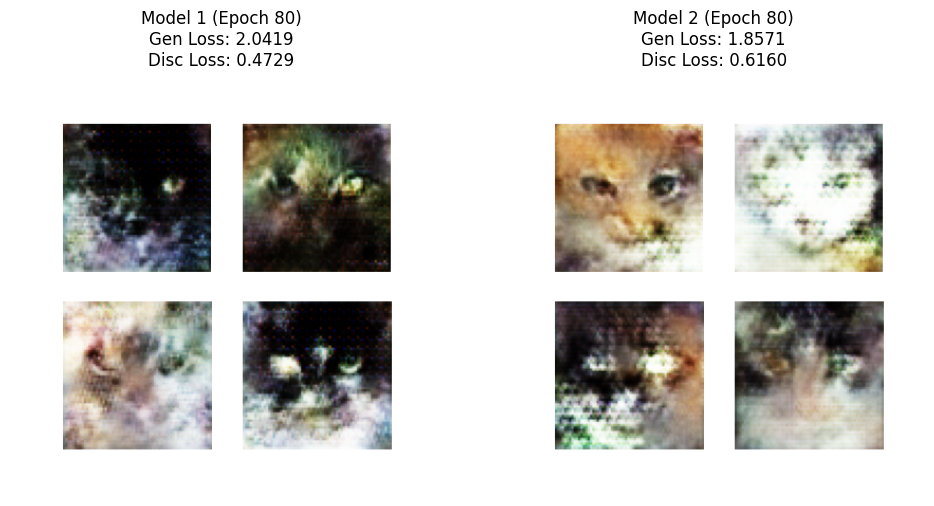

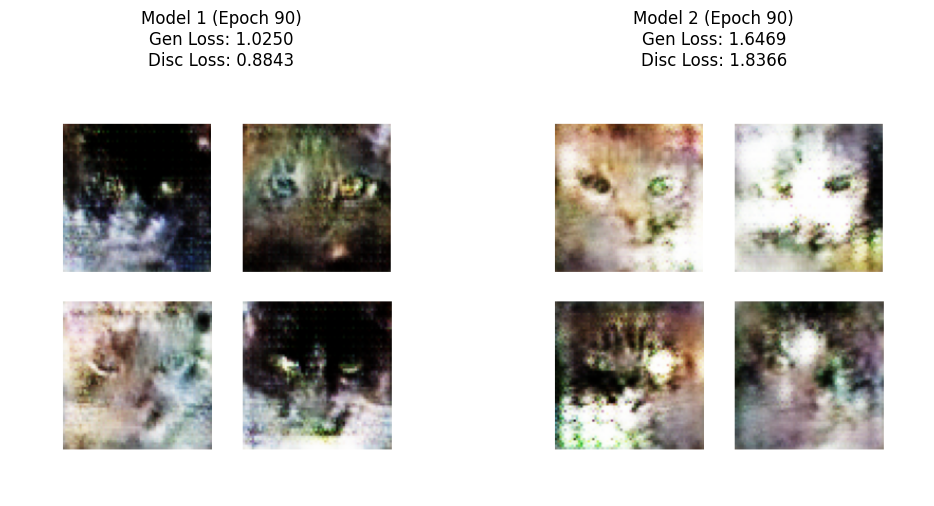

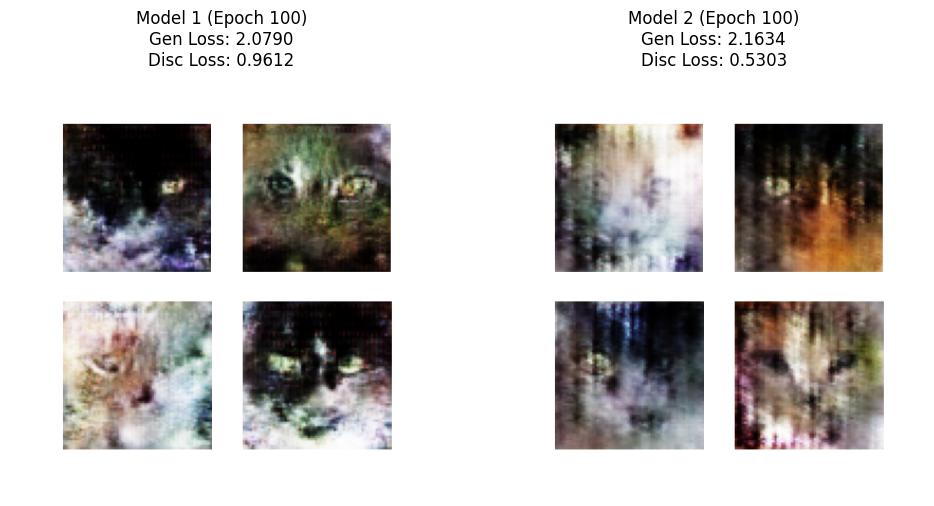

In [40]:
from IPython.display import display
from PIL import Image

# Directories where images for the models are saved
output_dir_model1 = "generated_images_model1"
output_dir_model2 = "generated_images_model2"

# Create directories if they don't exist
os.makedirs(output_dir_model1, exist_ok=True)
os.makedirs(output_dir_model2, exist_ok=True)

# Function to display images side by side
def display_images_side_by_side(epoch_range):
    for epoch in epoch_range:
        # Paths for images of the same epoch from both models
        img_path_model1 = os.path.join(output_dir_model1, f"epoch_{epoch}.png")
        img_path_model2 = os.path.join(output_dir_model2, f"epoch_{epoch}.png")

        # Load images if they exist
        if os.path.exists(img_path_model1) and os.path.exists(img_path_model2):
            img_model1 = Image.open(img_path_model1)
            img_model2 = Image.open(img_path_model2)

            # Plot images side by side
            fig, axes = plt.subplots(1, 2, figsize=(10, 5))

            axes[0].imshow(img_model1)
            axes[0].axis("off")
            axes[0].set_title(f"Model 1 (Epoch {epoch})\n"
                              f"Gen Loss: {generator_losses[epoch-1]:.4f}\n"
                              f"Disc Loss: {discriminator_losses[epoch-1]:.4f}")

            axes[1].imshow(img_model2)
            axes[1].axis("off")
            axes[1].set_title(f"Model 2 (Epoch {epoch})\n"
                              f"Gen Loss: {generator_losses2[epoch-1]:.4f}\n"
                              f"Disc Loss: {discriminator_losses2[epoch-1]:.4f}")

            plt.tight_layout()
            plt.show()

# Display images side by side for epochs 10, 20, ..., 100
display_images_side_by_side(range(10, 101, 10))

# Comparison of Two Models

#### **First Model**
- **Generator:**
  - Structure:
    - Dense layer
    - Followed by 2 Convolutional layers
    - Other layers in between
- **Discriminator:**
  - Structure:
    - 3 Conv2D layers
    - Followed by a Dense layer
- **Performance:**
  - Minimum Generator Loss: **0.91**
  - Minimum Discriminator Loss: **0.06**
- **Training Observation:**
  - Generator losses show **fluctuations** during training, with some losses exceeding 2.
- **Image Quality:**
  - Images generated are of **lower quality** compared to the second model.

---

#### **Second Model**
- **Generator:**
  - Structure:
    - Dense layer
    - Followed by 3 Convolutional layers
    - Other layers in between
- **Discriminator:**
  - Structure:
    - 3 Conv2D layers
    - Followed by a Dense layer (same as the first model)
- **Performance:**
  - Minimum Generator Loss: **0.77**
  - Minimum Discriminator Loss: **0.14**
- **Training Observation:**
  - Generator losses are **more consistent**, with values close to or below 2.
- **Image Quality:**
  - Images generated are **slightly better** than those in the first model.
  - **Additional training epochs** may further improve the quality and highlight differences more clearly.

---

### **Key Observations**
1. The **Discriminator** remains the same in both models.
2. The improved **Generator** structure in the second model:
   - Led to **lower and more stable Generator losses**.
   - Produced **slightly better image quality**, though further training may amplify this improvement.
3. The first model exhibited **greater fluctuations in Generator loss** and **poorer image quality** overall.
